In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#function that takes a SQL query as an argument and returns a df
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

#function that takes a SQL command and executes it using sqlite module
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#function to return a list of all tables and views in the database
def show_tables():
    q = '''
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [2]:
#the number and percentage of tracks sold in USA by genre
usa_sale = '''
WITH usa_count AS
    (
    SELECT invoice_line_id
    FROM invoice i
    INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    WHERE billing_country = 'USA'
    )

SELECT 
    g.name genre,
    COUNT(invoice_line_id) number_of_tracks,
    CAST(COUNT(invoice_line_id) AS FLOAT) / CAST((SELECT COUNT(*) FROM usa_count) AS FLOAT) percentage
FROM invoice i
INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
INNER JOIN track t ON t.track_id = il.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
WHERE billing_country = 'USA'
GROUP BY genre
ORDER BY number_of_tracks DESC
LIMIT 10
'''
run_query(usa_sale)

,genre,number_of_tracks,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [3]:
plt.rcParams.update({'font.size': 18}) #setting up font

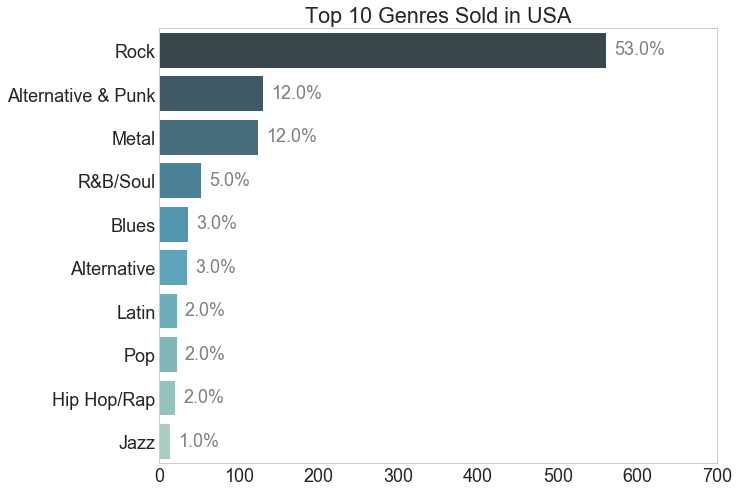

In [4]:
df_usa = run_query(usa_sale)
sns.set_style('whitegrid')
ax, fig = plt.subplots(figsize=(10,8))
ax = sns.barplot(x='number_of_tracks', y='genre', data=df_usa, orient='h', palette='GnBu_d')
ax.set(ylabel='', xlabel='', title='Top 10 Genres Sold in USA', xlim=(0,700))
ax.grid(False)

for index, row in df_usa.iterrows():
    plt.text(x = row['number_of_tracks']+10, y = index+.1, s=(str(round(row['percentage'],2)*100)+'%'),
            color='grey')

According to this graph, rock isn't dead! Rock is the most popular genre among the American chinook customers. This is followed by Alternative & Punk, Metal and R&B/Soul. Blues and Alternative genres are tied at 5th place, whereas Latin, Pop and Hip Hop/Rap are seemingly tied at 7th. Lastly, Jazz is the 10th most popular genre.

Next, we will take a look at the performances of each sales support agent.

In [5]:
sales = '''
SELECT
    e.first_name || ' ' || e.last_name employee_name,
    e.hire_date,
    e.birthdate,
    SUM(i.total) total_amount
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i on i.customer_id = c.customer_id
WHERE title='Sales Support Agent'
GROUP BY e.employee_id
'''
run_query(sales)

,employee_name,hire_date,birthdate,total_amount
0,Jane Peacock,2017-04-01 00:00:00,1973-08-29 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1947-09-19 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1965-03-03 00:00:00,1393.92


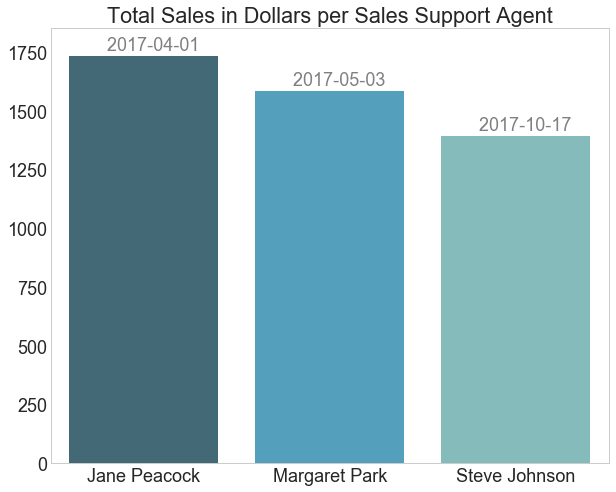

In [6]:
df_sales = run_query(sales)
ax, fig = plt.subplots(figsize=(10,8))
ax = sns.barplot(
    x='employee_name', 
    y='total_amount', 
    data=df_sales, 
    palette='GnBu_d',
    
)
ax.set(
    xlabel='', 
    ylabel='', 
    title='Total Sales in Dollars per Sales Support Agent', 
    ylim=(0,1850)
)
ax.grid(False)

for index, row in df_sales.iterrows():
    plt.text(x = index-0.2, y = row['total_amount']+25, 
             s=row['hire_date'].replace('00:00:00', ''), 
             color='grey')

The top performing Sale Support Agent is Jane Peacock, followed by Margaret Park and Steve Johnson. The main contributing factor to this is the hire date; seniore sales support agents perform better than the junior ones. That being said, Steve is doing a fantastic job, since he only started on October 17, 2017, and he is keeping up his sales relatively close to his two other senior colleagues.

We will not analyze the sales data from each different country.

In [7]:
country = '''
WITH country_label AS (
SELECT
    country,
    COUNT(distinct customer_id),
    CASE
        WHEN COUNT(distinct customer_id) >= 2 THEN country
        ELSE 'Other'
    END AS new_country
FROM customer
GROUP BY country
    )

SELECT
    cl.new_country country,
    COUNT(distinct c.customer_id) number_of_customers,
    SUM(i.total) total_sales_value,
    SUM(i.total) / COUNT(distinct i.invoice_id) average_order_value,
    SUM(i.total) / COUNT(distinct c.customer_id) sales_per_customer,
    CASE
        WHEN cl.new_country = 'Other' THEN 1
        ELSE 0
    END AS sort
FROM customer c
LEFT JOIN invoice i ON i.customer_id = c.customer_id
LEFT JOIN country_label cl ON cl.country = c.country
GROUP BY 1
ORDER BY sort ASC, number_of_customers DESC
'''

run_query(country)

,country,number_of_customers,total_sales_value,average_order_value,sales_per_customer,sort
0,USA,13,1040.49,7.942672,80.037692,0
1,Canada,8,535.59,7.047237,66.948750,0
2,Brazil,5,427.68,7.011148,85.536000,0
3,France,5,389.07,7.781400,77.814000,0
4,Germany,4,334.62,8.161463,83.655000,0
5,United Kingdom,3,245.52,8.768571,81.840000,0
6,Czech Republic,2,273.24,9.108000,136.620000,0
7,India,2,183.15,8.721429,91.575000,0
8,Portugal,2,185.13,6.383793,92.565000,0
9,Other,15,1094.94,7.448571,72.996000,1


In [8]:
plt.rcParams.update({'font.size': 15}) #setting up font

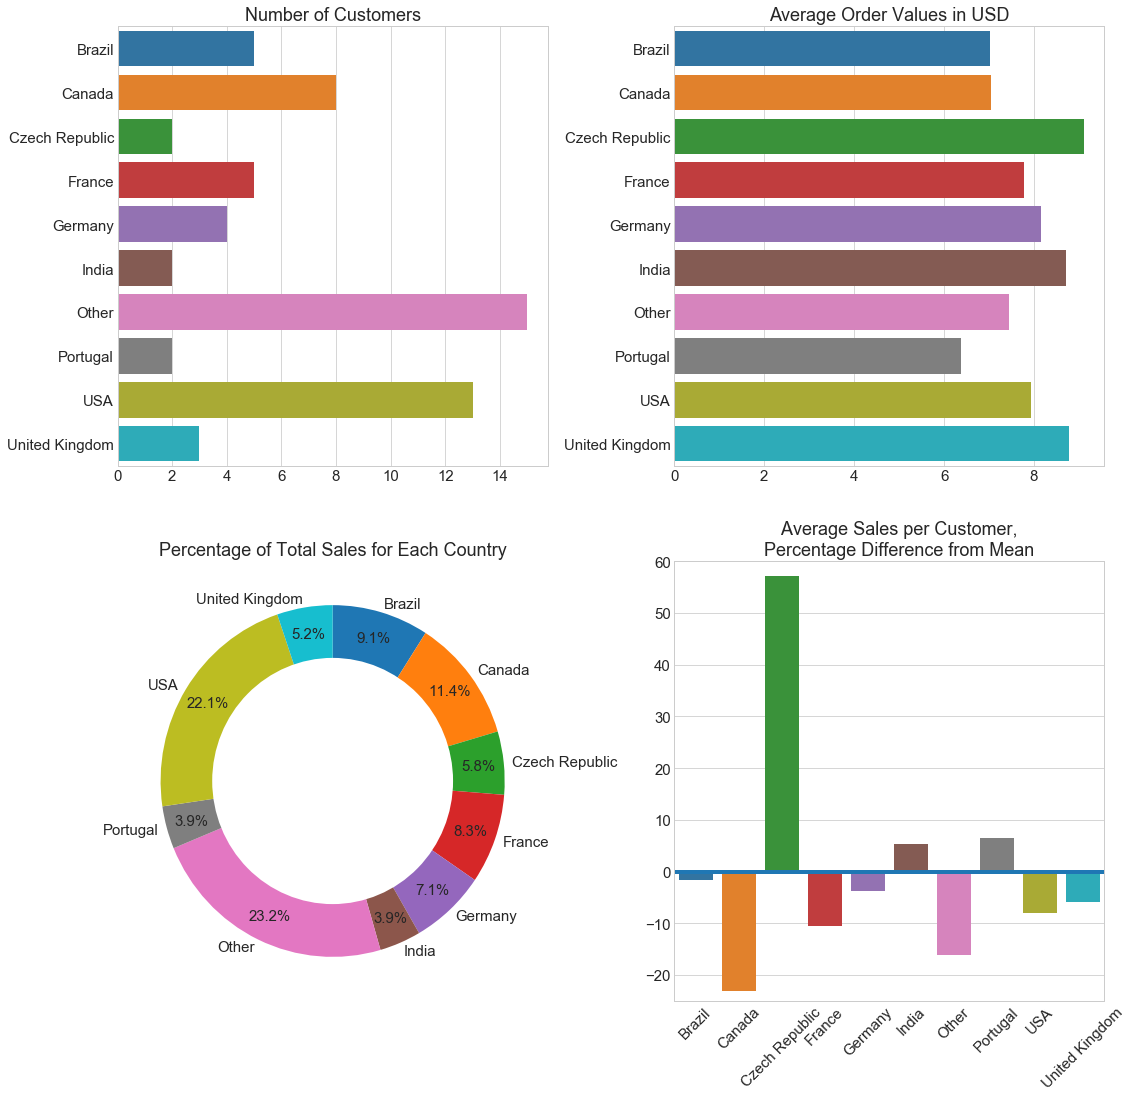

In [9]:
df = run_query(country)
df = df.sort_values(by=['country'])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 15.5))
ax1, ax2, ax3, ax4 = axes.flatten()

sns.barplot(
    x='number_of_customers',
    y='country',
    data=df,
    palette='tab10',
    ax=ax1
)
ax1.set(
    ylabel='',
    xlabel='',
    title='Number of Customers'
)


sns.barplot(
    x='average_order_value',
    y='country',
    data=df,
    palette='tab10',
    ax=ax2
)
ax2.set(
    ylabel='',
    xlabel='',
    title='Average Order Values in USD'
)

df['total_sales_value'].plot.pie(
    ax=ax3, 
    labels=df['country'], 
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    labeldistance=1.05,
    counterclock=False,
    colormap='tab10'
)
ax3.set(
    ylabel='',
    title='Percentage of Total Sales for Each Country'
)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax3.add_artist(centre_circle)

df['dif_mean_sales_cust'] = df['sales_per_customer'] * 100 / df['sales_per_customer'].mean() - 100
sns.barplot(
    x='country',
    y='dif_mean_sales_cust',
    data=df,
    palette='tab10',
    ax=ax4
)
ax4.set(
    ylabel='',
    xlabel='',
    title='''
    Average Sales per Customer,
    Percentage Difference from Mean''',
    ylim=(-25,60)
)
ax4.tick_params(axis='x', labelrotation=45)
ax4 = plt.plot([-1, 10], [0, 0], lw=4)

plt.tight_layout()

Note that countries with less than 2 customers were categorized as 'Other'.

Findings here are as follows:
* USA has the most amount of customers, followed by Canada and Brazil. In a similar pattern, USA makes the most amount of total sales, excluding 'Other', followed by Canada then Brazil.
* Average order values per customer were close in their values.
* When average sales per customer were considered, only a few countries exceeded the mean. India and Portugal had slightly higher average sales per customer compared to the overal mean. Czech Republic greatly exceeded the other countries. This may suggest that there is a greater demand for chinook products at Czech Republic.

In [10]:
album_purchase = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY invoice_id
    ),
album_status AS
    (
    SELECT
        ift.*,
        CASE
            WHEN
                (
                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = ift.first_track_id
                                    )

                EXCEPT

                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ift.invoice_id
                ) IS NULL

                AND

                (
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ift.invoice_id

                EXCEPT

                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = ift.first_track_id
                                    )
                )IS NULL
            THEN "Yes"
            ELSE "No"
        END AS album_purchase
    FROM invoice_first_track ift
    )
    
SELECT
    album_purchase,
    COUNT(invoice_id) number_of_purchases,
    CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) percentage
FROM album_status
GROUP BY album_purchase
'''

run_query(album_purchase)

,album_purchase,number_of_purchases,percentage
0,No,500,0.814332
1,Yes,114,0.185668


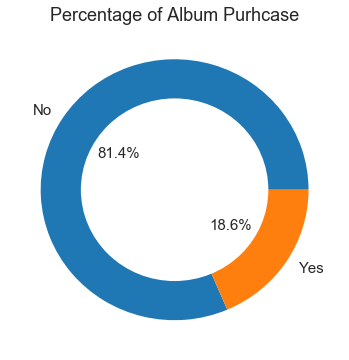

In [11]:
fig, ax = plt.subplots(figsize=(6,6))

df_album_purchase = run_query(album_purchase)
df_album_purchase['percentage'].plot.pie(
    ax=ax,
    autopct='%1.1f%%',
    labels=df_album_purchase['album_purchase'],
    pctdistance=0.5,
    labeldistance=1.1
)
ax.set(
    title='Percentage of Album Purhcase',
    ylabel=''
)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax.add_artist(centre_circle)

Here, we queried to see how many invoices buy full albums, which only 18.6% accounted for. To better meet customer needs, the store website should make the functionality of purchasing individual tracks a lot easier and put less emphasis on full album purchases.